In [10]:
import pickle, glob

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import savgol_filter
from scipy import fftpack
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.ndimage.filters import gaussian_filter1d

import statsmodels.api as sm

from statsmodels.nonparametric.kernel_regression import KernelReg

from ast import literal_eval
from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import StrMethodFormatter, NullFormatter, ScalarFormatter


# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
#mpl.rcParams['pdf.fonttype'] = 42

path_to_results = r'/Users/Guille/Desktop/caiso_power/results/'
path_to_images  = r"/Users/Guille/Desktop/caiso_power/images/"
path_to_models  = r'/Users/Guille/Desktop/caiso_power/models/'
path_to_aux     = r'/Users/Guille/Desktop/caiso_power/data/auxiliary/'
path_to_maps    = r'/Users/Guille/Desktop/caiso_power/data/maps/'
path_to_prc     = r'/Users/Guille/Desktop/caiso_power/data/processed/'

# Get California unlities and remove the ones that are not CAISO
_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
_US    = gpd.read_file(path_to_maps + r"US/tl_2022_us_state.shp")
_CAISO = gpd.read_file(path_to_maps + r"CAISO/Balancing_Authority_Areas_in_CA.shp")
_CAISO = _CAISO.iloc[[1, 7]].to_crs("EPSG:4326")

resources_  = ['load', 'solar', 'wind']
dl_methods_ = ['BLR', 'RVM', 'GPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']

colors_1_ = ['#7d6674', '#006995', '#f48d64', '#09155a', '#e6cd94', '#0041a5']
colors_2_ = ['#92918B', '#126463', '#2CB7B5', '#756A00', '#CA8250', '#D8A581', '#1F390D']

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_18860/1668698842.py:20: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


# Baseline Model Scores

In [11]:
def _dataframe(data_, index_, columns_, method, resource):
    df_             = pd.DataFrame(data_, index = index_, columns = columns_)
    df_['zone']     = df_.index
    df_['method']   = method
    df_['resource'] = resource
    df_             = df_.reset_index(drop = True)
    return df_

Persistence_ = np.array([[1432.425405, 0.191187], [1580.078333,  -6.230624], [299.133371, -0.699760]])
CAISO_       = np.array([[607.075561, 273.938328], [647.596172, 267.898981], [164.827576, 72.686353]])
Climatoloty_ = np.array([[1336.276707, 9.815701], [1541.191602, -4.939872], [289.481101, 1.025492]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'load')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'load')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'load')
ref_         = pd.concat([Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)

Persistence_ = np.array([[244.096715, -1.377402], [933.148375, -10.316115], [269.491617, -2.408633]])
CAISO_       = np.array([[255.950023, -95.328823], [649.992549, -258.398304], [209.531956, -65.376801]])
Climatoloty_ = np.array([[216.941925, -3.550991], [789.308296, -14.495869], [218.326947, -5.045071]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'solar')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'solar')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'solar')
ref_         = pd.concat([ref_, Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)

Persistence_ = np.array([[455.203618, -0.012404], [1170.880167, -4.723570]])
CAISO_       = np.array([[166.998352, -41.077674], [387.69634, -156.006200]])
Climatoloty_ = np.array([[354.895993, -1.108021], [946.000155, -12.270927]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'wind')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'wind')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'wind')
ref_         = pd.concat([ref_, Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)
print(ref_)

           RMSE         MBE  zone       method resource
0   1432.425405    0.191187  NP15  Presistence     load
1   1580.078333   -6.230624  SP15  Presistence     load
2    299.133371   -0.699760  ZP26  Presistence     load
3   1336.276707    9.815701  NP15  Climatology     load
4   1541.191602   -4.939872  SP15  Climatology     load
5    289.481101    1.025492  ZP26  Climatology     load
6    607.075561  273.938328  NP15        CAISO     load
7    647.596172  267.898981  SP15        CAISO     load
8    164.827576   72.686353  ZP26        CAISO     load
9    244.096715   -1.377402  NP15  Presistence    solar
10   933.148375  -10.316115  SP15  Presistence    solar
11   269.491617   -2.408633  ZP26  Presistence    solar
12   216.941925   -3.550991  NP15  Climatology    solar
13   789.308296  -14.495869  SP15  Climatology    solar
14   218.326947   -5.045071  ZP26  Climatology    solar
15   255.950023  -95.328823  NP15        CAISO    solar
16   649.992549 -258.398304  SP15        CAISO  

In [31]:
def _make_ref_plot(Scores_, zones_p_, score, resource, legend_labels_, legend_title, colors_, ndecimals = 0,
                                                                                     score_key = 'value',
                                                                                     ref_      = [],
                                                                                     xlabel    = '',
                                                                                     ylabel    = '', 
                                                                                     title     = '', 
                                                                                     suptitle  = '', 
                                                                                     letter    = '',
                                                                                     y_lim     = 0,
                                                                                     save      = False, 
                                                                                     legend    = False, 
                                                                                     filename  = 'noname.pdf'):
    
    methods_ = Scores_['method'].unique()
    zones_   = Scores_.loc[Scores_['resource'] == resource, 'zone'].unique()

    x_     = np.linspace(0, .333*len(methods_), len(methods_))
    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(zones_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    refs_ = [1000., 500., 750.]
    ticks_ = []
    j = 0
    print(Scores_)
    for zone in zones_p_:
        i = 0
        for method in methods_:
            idx_  = (Scores_['method'] == method) & (Scores_['zone'] == zone) & (Scores_['resource'] == resource)
            value = Scores_.loc[idx_, score_key].to_numpy()[0]
            
            if len(ref_) > 0:
                y = np.around((1. - value/ref_[j])*100, ndecimals)
                p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                             zorder = 9, 
                                             align  = 'center')
            else:
                y = np.around(value, ndecimals)
                p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                             zorder = 9, 
                                             align  = 'center')
            plt.bar_label(p, labels=[f'{x:,.0f}' for x in p.datavalues], size = 14)
           
            i += 1
        
        ticks_.append(x_.mean())
        x_ += offset
        j += 1
    idx_  = Scores_['resource'] == resource
    if y_lim == 0.:
        y_lim = Scores_.loc[idx_, score].max()
    plt.ylim(-y_lim*0.005, y_lim*1.125)

    plt.xticks(ticks_[:len(zones_p_)], zones_p_, fontsize = 10)
    
    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1.3, .825],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    ax.text(-1.3, y_lim*1.25, letter, fontsize = 20, 
                                      weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    
    plt.show()

           RMSE         MBE  zone       method resource
0   1432.425405    0.191187  NP15  Presistence     load
1   1580.078333   -6.230624  SP15  Presistence     load
2    299.133371   -0.699760  ZP26  Presistence     load
3   1336.276707    9.815701  NP15  Climatology     load
4   1541.191602   -4.939872  SP15  Climatology     load
5    289.481101    1.025492  ZP26  Climatology     load
6    607.075561  273.938328  NP15        CAISO     load
7    647.596172  267.898981  SP15        CAISO     load
8    164.827576   72.686353  ZP26        CAISO     load
9    244.096715   -1.377402  NP15  Presistence    solar
10   933.148375  -10.316115  SP15  Presistence    solar
11   269.491617   -2.408633  ZP26  Presistence    solar
12   216.941925   -3.550991  NP15  Climatology    solar
13   789.308296  -14.495869  SP15  Climatology    solar
14   218.326947   -5.045071  ZP26  Climatology    solar
15   255.950023  -95.328823  NP15        CAISO    solar
16   649.992549 -258.398304  SP15        CAISO  

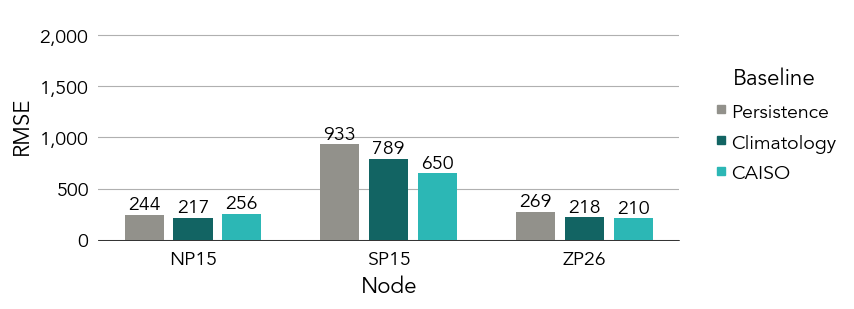

In [32]:
score    = 'RMSE'
resource = 'solar'
y_lim    = 2000.
#zones_   = ['PGE', 'SCE', 'SDGE']
zones_   = ['NP15', 'SP15', 'ZP26']
#zones_   = ['NP15', 'SP15']

_make_ref_plot(ref_, zones_, score, resource, colors_        = colors_2_, 
                                              ndecimals      = 0, 
                                              score_key      = score,
                                              legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                                              title          = r'', 
                                              suptitle       = r'',
                                              xlabel         = r'Node',
                                              ylabel         = r'RMSE',
                                              legend_title   = r'Baseline',
                                              letter         = '',
                                              y_lim          = y_lim,
                                              save           = True, 
                                              legend         = True, 
                                              filename       = 'ref_{}_{}.png'.format(score, resource))



# Machine Learning Model Scores

In [47]:
def _load_files(path_to_files, zones_):
    file_ = pd.read_csv(path_to_files) 
    file_ = file_.rename(columns = {'LogS_': 'LogS', 
                                    'ES_': 'ES', 
                                    'VS_': 'VS', 
                                    'IS60_': 'IS60',
                                    'IS80_': 'IS80',
                                    'IS90_': 'IS90',
                                    'IS95_': 'IS95',
                                    'IS975_': 'IS975',
                                    'CI60_': 'CI60',
                                    'CI80_': 'CI80',
                                    'CI90_': 'CI90',
                                    'CI95_': 'CI95',
                                    'CI975_': 'CI975'})

    file_['RMSE'] = 0.
    
    for zone in zones_:
        file_['RMSE'] += file_['RMSE_' + zone]/len(zones_)
    
    file_['IS'] = file_['IS60'] + file_['IS80'] + file_['IS90'] + file_['IS95'] + file_['IS975']

    return file_

resources_  = ['wind']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']

zones_  = ['NP15', 'SP15', 'ZP26']
zones_  = ['NP15', 'SP15']

times_  = ['sparse_training_time', 'dense_training_time', 'testing_time', 'prob_testing_time']
scores_ = ['RMSE', 'LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975', 'RMSE_NP15', 'RMSE_SP15', 'RMSE_ZP26']
scores_ = ['RMSE', 'LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975', 'RMSE_NP15', 'RMSE_SP15']

Scores_ = []

N_tr = 243

for score in ['RMSE', 'LogS', 'ES', 'VS']:
    for resource in resources_:
        for dl_method in dl_methods_:
            for sl_method in sl_methods_:

                file_name = r'{}/'.format(dl_method) + 'val-{}'.format(resource) + '-{}'.format(sl_method) + '-{}'.format(dl_method) + '.csv'
                file_     = _load_files(path_to_results + file_name, zones_)
                i_exp     = file_.loc[np.argmin(file_[score]), 'experiment']
                #print(resource, dl_method, sl_method, i_exp)

                file_name = r'{}/'.format(dl_method) + 'test-{}'.format(resource) + '-{}'.format(sl_method) + '-{}'.format(dl_method) + '.csv'
                file_     = _load_files(path_to_results + file_name, zones_)
                param     = file_.loc[file_['experiment'] == i_exp, 'parameters'].to_numpy()[0]
                dim       = file_.loc[file_['experiment'] == i_exp, 'dimensions'].to_numpy()[0]
                
                tr  = file_.loc[file_['experiment'] == i_exp, 'sparse_training_time'].to_numpy()[0] + file_.loc[file_['experiment'] == i_exp, 'dense_training_time'].to_numpy()[0]
                ts  = file_.loc[file_['experiment'] == i_exp, 'testing_time'].to_numpy()[0] + file_.loc[file_['experiment'] == i_exp, 'prob_testing_time'].to_numpy()[0]
                ts /= N_tr
                
                meta_   = [resource, sl_method, dl_method, param, i_exp, dim, score, tr, ts]
                values_ = [file_.loc[file_['experiment'] == i_exp, score].to_numpy()[0] for score in scores_]

                Scores_.append(np.array(meta_ + values_))

Scores_ = pd.DataFrame(np.stack(Scores_), columns = ['resource', 
                                                     'sparse_method', 
                                                     'dense_method', 
                                                     'parameters', 
                                                     'experiment', 
                                                     'dimensions', 
                                                     'score',
                                                     'training_time',
                                                     'testing_time'] + scores_)
print(Scores_)
Scores_.to_csv(path_to_models + 'prob_model_selection_{}.csv'.format(resources_[-1]), index = False)

   resource sparse_method dense_method      parameters experiment dimensions  \
0      wind         lasso          BLR       (0.0001,)          1       1162   
1      wind           OMP          BLR          (640,)          6       1268   
2      wind   elastic_net          BLR     (0.1, 0.01)         12       1137   
3      wind   group_lasso          BLR    (0.01, 0.25)          0       1006   
4      wind         lasso          RVM   (0.1, 1000.0)         27         57   
..      ...           ...          ...             ...        ...        ...   
59     wind   group_lasso          GPR  (0.01, 1.0, 7)         19        348   
60     wind         lasso        MTGPR       (0.05, 5)         27         41   
61     wind           OMP        MTGPR         (80, 5)         17        152   
62     wind   elastic_net        MTGPR   (0.1, 0.5, 5)         72         91   
63     wind   group_lasso        MTGPR  (0.1, 0.75, 5)         32        116   

   score       training_time        tes

## Forecasting Skill 

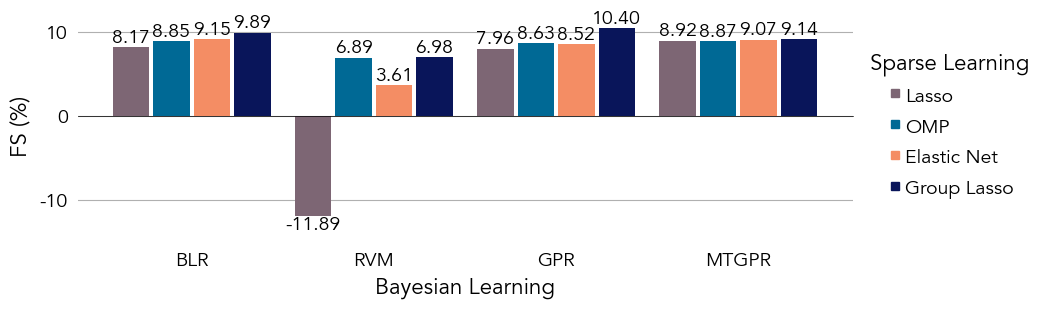

In [44]:
def _make_fs_plot(Scores_, ref_, zones_, resource, legend_labels_, legend_title, colors_, ndecimals = 0,
                                                                                   score = 'RMSE',
                                                                                   xlabel    = '',
                                                                                   ylabel    = '', 
                                                                                   title     = '', 
                                                                                   letter    = '', 
                                                                                   suptitle  = '', 
                                                                                   save      = False, 
                                                                                   legend    = False, 
                                                                                   filename  = 'noname.pdf'):
    
    sparse_methods_ = Scores_['sparse_method'].unique()
    dense_methods_  = Scores_['dense_method'].unique()

    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(dense_methods_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    ticks_  = []
    values_ = []
    j = 0
    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_  = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            
            idx_2_  = (ref_['method'] == 'CAISO') & (ref_['resource'] == resource) #& (ref_['zone'] == zone)
            
            
            value = 1. - np.min(float(Scores_.loc[idx_1_, score].to_numpy()[0]))/ref_.loc[idx_2_, score].to_numpy().mean()

            
            y = np.around(value*100, ndecimals)

            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 14)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(dense_methods_)], dense_methods_, fontsize = 10)
    
    y_min = -15.
    y_max = 12.5
    plt.ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)

    ax.text(-1.25, y_max*1.1, letter, fontsize = 20, 
                                      weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    plt.show()
    
    
resource = 'solar'
zones_   = ['NP15', 'SP15', 'ZP26']
score    = 'RMSE'

_make_fs_plot(Scores_, ref_, zones_, resource, colors_        = colors_1_, 
                                               score          = score,
                                               ndecimals      = 2, 
                                               legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                               title          = '', 
                                               xlabel         = r'Bayesian Learning',
                                               ylabel         = r'FS (%)',
                                               legend_title   = r'Sparse Learning',
                                               letter         = '',
                                               save           = True, 
                                               legend         = True, 
                                               filename       = 'fs_{}_{}.png'.format(score, resource))

## Proper Scoring 

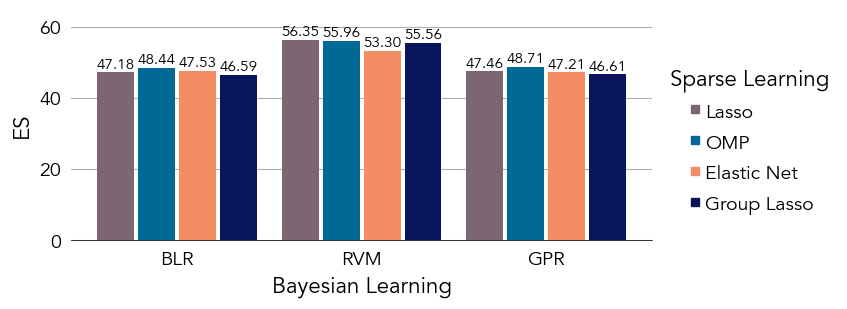

In [231]:
def _make_scores_plot(Scores_, zones_p_, resource, legend_labels_, legend_title, colors_, ndecimals, score     = '', 
                                                                                                           xlabel    = '',
                                                                                                           ylabel    = '', 
                                                                                                           title     = '', 
                                                                                                           letter    = '', 
                                                                                                           suptitle  = '', 
                                                                                                           save      = False, 
                                                                                                           legend    = False, 
                                                                                                           filename  = 'noname.pdf'):
    

    sparse_methods_ = Scores_['sparse_method'].unique()
    dense_methods_  = Scores_['dense_method'].unique()

    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(dense_methods_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    ticks_  = []
    values_ = []
    j = 0
    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_  = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
                     
            
            value = float(Scores_.loc[idx_1_, score].to_numpy()[0])
            values_.append(value)
            
            y = np.around(value, ndecimals)

            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 11)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(dense_methods_)], dense_methods_, fontsize = 10)
    
    y_min = -.1
    y_max = np.max(np.array(values_))*1.15
    
    plt.ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .825],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                      linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)

    ax.text(-1.25, y_max*1.1, letter, fontsize = 20, 
                                      weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    plt.show()
    
    
resource = 'solar'
zones_   = ['NP15', 'SP15', 'ZP26']
score    = 'ES'

_make_scores_plot(Scores_, zones_, resource, colors_        = colors_1_, 
                                             ndecimals      = 2, 
                                             legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                             title          = '', 
                                             score          = score,
                                             xlabel         = r'Bayesian Learning',
                                             ylabel         = score,
                                             legend_title   = r'Sparse Learning',
                                             letter         = '',
                                             save           = True, 
                                             legend         = True, 
                                             filename       = 'score_{}_{}.png'.format(score, resource))

## Interval Score Comparison

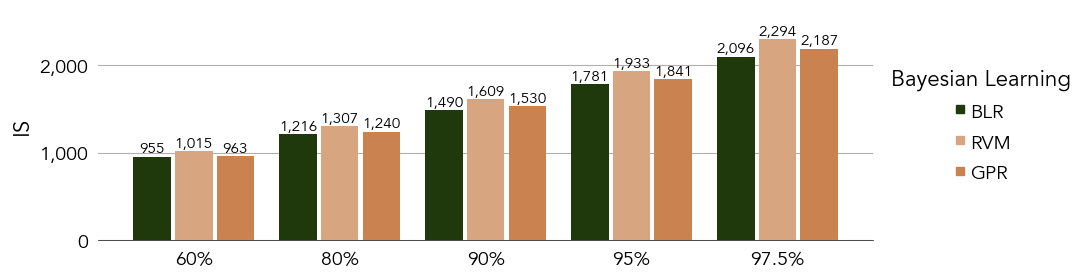

In [222]:
def _make_inteval_scores_plot(Scores_, zones_p_, resource, legend_labels_, legend_title, colors_, ndecimals, score     = '', 
                                                                                                           xlabel    = '',
                                                                                                           ylabel    = '', 
                                                                                                           title     = '', 
                                                                                                           letter    = '', 
                                                                                                           suptitle  = '', 
                                                                                                           save      = False, 
                                                                                                           legend    = False, 
                                                                                                           filename  = 'noname.pdf'):
    

    interval_scores_ = ['IS60','IS80','IS90','IS95', 'IS975']
    dense_methods_   = Scores_['dense_method'].unique()

    
    x_ = np.linspace(0, .333*len(dense_methods_), len(dense_methods_))

    width  = 0.45
    offset = 1.75
    
    fig = plt.figure(figsize = (len(interval_scores_)*2., 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    ticks_  = []
    values_ = []
    j = 0
    for interval_score in interval_scores_:
        i = 0
        for dense_method in dense_methods_:
     
            idx_1_  = (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
                     
            df_   = Scores_.loc[idx_1_]
            df_   = df_.iloc[np.argmin(Scores_.loc[idx_1_, score].to_numpy().astype(float))]
            value = float(df_[interval_score])
            values_.append(value)
            
            y = np.around(value, ndecimals)
            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.0f}' for x in p.datavalues], size = 11)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(interval_scores_)], ['60%', '80%', '90%', '95%', '97.5%'], fontsize = 10)
    
    y_min = -.1
    y_max = np.max(np.array(values_))*1.15
    
    plt.ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .825],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    plt.ylabel('IS', fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    ax.text(-1.25, y_max*1.1, letter, fontsize = 20, 
                                      weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    plt.show()
    
    
resource = 'solar'
zones_   = ['NP15', 'SP15', 'ZP26']
score    = 'LogS'

_make_inteval_scores_plot(Scores_, zones_, resource, colors_        = colors_2_[::-1], 
                                                     ndecimals      = 0, 
                                                     legend_labels_ = ['BLR','RVM','GPR'], 
                                                     title          = '', 
                                                     score          = score,
                                                     xlabel         = r'',
                                                     ylabel         = r'LogS',
                                                     legend_title   = r'Bayesian Learning',
                                                     letter         = '',
                                                     save           = True, 
                                                     legend         = True, 
                                                     filename       = 'IS_{}_{}.png'.format(score, resource))

# Computing Time

In [63]:
path_to_mdls = r'/Users/Guille/Desktop/caiso_power/proceeding_model/'

resources_ = ['solar']
sl_models_ = ['OMP', 'lasso', 'elastic_net', 'group_lasso']
dl_models_ = ['BLR', 'RVM', 'GPR']
scores_    = ['ES', 'VS', 'LogS']

N_tr  = 243
time_ = []
for resource in resources_:    
    for score in scores_:
        for sl_model in sl_models_:
            for dl_model in dl_models_:
                
                filename = '{}-{}-{}-{}.pkl'.format(resource, sl_model, dl_model, score)
                #print(filename)
                with open(path_to_mdls + filename, 'rb') as f:
                    _model = pickle.load(f)                    
                tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_tr

                time_.append([resource, score, sl_model, dl_model, tr, ts])

time_ = pd.DataFrame(np.stack(time_), columns = ['resource', 'score', 'sparse_method', 'dense_method', 'train', 'test'])
print(time_)

   resource score sparse_method dense_method               train  \
0     solar    ES           OMP          BLR   48.64168095588684   
1     solar    ES           OMP          RVM   32.85668706893921   
2     solar    ES           OMP          GPR  1714.9043922424316   
3     solar    ES         lasso          BLR   892.6130282878876   
4     solar    ES         lasso          RVM   936.3348281383514   
5     solar    ES         lasso          GPR  3229.6486542224884   
6     solar    ES   elastic_net          BLR  1140.0786068439484   
7     solar    ES   elastic_net          RVM  1150.9746165275574   
8     solar    ES   elastic_net          GPR   4719.365359783173   
9     solar    ES   group_lasso          BLR   5652.523215770721   
10    solar    ES   group_lasso          RVM   5738.600006818771   
11    solar    ES   group_lasso          GPR   6820.058078289032   
12    solar    VS           OMP          BLR   50.64794898033142   
13    solar    VS           OMP          RVM   3

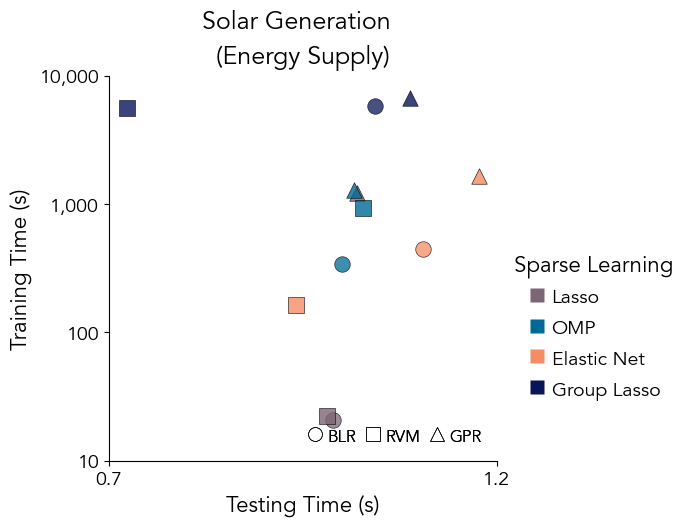

In [193]:
def _plot_computing_time(time_, resource, score, colors_, suptitle, title, save, legend, path, filename, y_min = 1):

    markers_       = ['o', 's', '^', 'd']
    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso']

    idx_1_ = (time_['resource'] == resource) & (time_['score'] == score)

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)


    fig = plt.figure(figsize = (5., 5.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 18, y = 1.0125)
    plt.title(title, fontsize = 18, y = 1.01)

    i = 0
    for sl_method in time_['sparse_method'].unique():

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for dl_method in time_['dense_method'].unique():

            idx_3_ = time_['dense_method'] == dl_method

            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]

            if j == 0:
                ax.scatter(time_p_['test'], time_p_['train'], s         = 125., 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.75,
                                                              facecolor = colors_[i])
            else:
                ax.scatter(time_p_['test'], time_p_['train'], s         = 125., 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.8,
                                                              facecolor = colors_[i])

            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    plt.xscale('symlog')
    plt.yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    plt.ylabel('Training Time (s)', fontsize = 16)
    plt.xlabel('Testing Time (s)', fontsize = 16)


    legend_title = "Sparse Learning"

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "None", 
                                        markersize      = 10,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 14}, 
                            title_fontsize = 16,
                            ncol           = 1, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .585],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = 10,
                                    markeredgewidth = .5,
                                    label           = 'BLR'))

    legend_.append(Line2D([0], [0], marker          = 's', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 10,
                                    markeredgewidth = .5,
                                    label           = 'RVM'))

    legend_.append(Line2D([0], [0], marker          = '^', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 10,
                                    markeredgewidth = .5,
                                    label           = 'GPR'))

    # legend_.append(Line2D([0], [0], marker          = 'D', 
    #                                 color           = "None",
    #                                 markerfacecolor = 'None', 
    #                                 markeredgecolor = "k", 
    #                                 markersize      = 10,
    #                                 markeredgewidth = .5,
    #                                 label           = 'MT-GPR'))

    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 4, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., 0.125],
                            frameon        = False)

        ax.add_artist(_leg_2)

    plt.ylim(y_min, 10000)
    #plt.xlim(0, )

    if save:
        plt.savefig(path + filename, bbox_inches = 'tight',
                                     dpi         = 350)


    plt.show()

resource = 'solar'
score = 'LogS'
    
_plot_computing_time(time_, resource, score, colors_  = colors_1_,
                                             suptitle = 'Solar Generation', 
                                             title    = '(Energy Supply)', 
                                             save     = False, 
                                             legend   = True, 
                                             path     = path_to_images, 
                                             y_min    = 10,
                                             filename = 'computing_time_{}_{}.pdf'.format(resource, score))

# Forecating Scenarios

In [48]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal

path_to_models = '/Users/Guille/Desktop/caiso_power/proceeding_model/'
path_to_prc    = r'/Users/Guille/Desktop/caiso_power/data/processed/'

file_name = r'solar-elastic_net-BLR-LogS.pkl'

baseline = 'caiso'
i_zone   = 1

zones_ = ['NP15', 'SP15', 'ZP26']

idx_1_  = (Scores_['sparse_method'] == 'lasso') & (Scores_['dense_method'] == 'GPR') & (Scores_['resource'] == 'solar') & (Scores_['score'] == 'LogS')
            
            
df_ = Scores_.loc[idx_1_].T
print(df_)

_model = pd.read_pickle(path_to_models + file_name)

print(_model['time'].shape)
print(_model['mask'].shape)
print(_model['weights'].shape)
print(_model['feature_labels'].shape)

print(_model['targets'].shape)
print(_model['targets_meta'].shape)

print(_model['mean'].shape)
print(_model['covariance'].shape)
print(_model['variance'].shape)
print(_model['samples'].shape)


file_name = 'solar-0-1-2_baselines.pkl'

_baselines = pd.read_pickle(path_to_prc + file_name)
print(_baselines.keys())

Empty DataFrame
Columns: []
Index: [resource, sparse_method, dense_method, parameters, experiment, dimensions, score, training_time, testing_time, RMSE, LogS, ES, VS, IS60, IS80, IS90, IS95, IS975, RMSE_NP15, RMSE_SP15]
(4, 1)
(9152,)
(3996, 3)
(4002,)
(243, 3, 24)
(243, 4)
(243, 3, 24)
(243, 3, 3, 24)
(243, 3, 24)
(243, 3, 24, 100)
dict_keys(['persitence', 'climatology', 'caiso'])


In [49]:
Y_ = _model['deterministic_scoring_all']
X_ = _model['baseline_scoring_all']

Y_ = Y_.loc[Y_['zone'] == zones_[i_zone]].reset_index(drop = True)
X_ = X_.loc[(X_['model'] == baseline) & (X_['zone'] == zones_[i_zone])].reset_index(drop = True)

Y_ = Y_.drop(columns = ['MBE', 'MAE', 'model', 'zone', 'sample']).rename(columns = {'RMSE': 'ml'})
X_ = X_.drop(columns = ['MBE', 'MAE', 'model', 'zone']).rename(columns = {'RMSE': 'caiso'})
X_ = pd.concat([X_, Y_], axis = 1)

X_['diff'] = X_['ml'] - X_['caiso']
X_['mean'] = np.mean(np.sqrt(_model['variance'])[:, i_zone, :], axis = 1)
X_['max']  = np.max(np.sqrt(_model['variance'])[:, i_zone, :], axis = 1)

meta_         = _model['targets_meta']
meta_['date'] = pd.to_datetime(meta_[["year", "month", "day"]])
meta_['date'] = meta_['date'].dt.strftime('%m/%d/%Y')

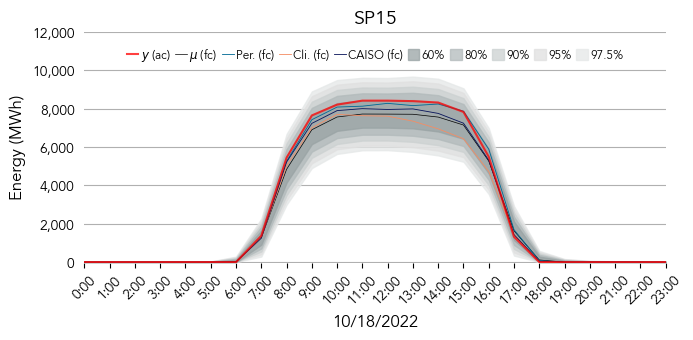

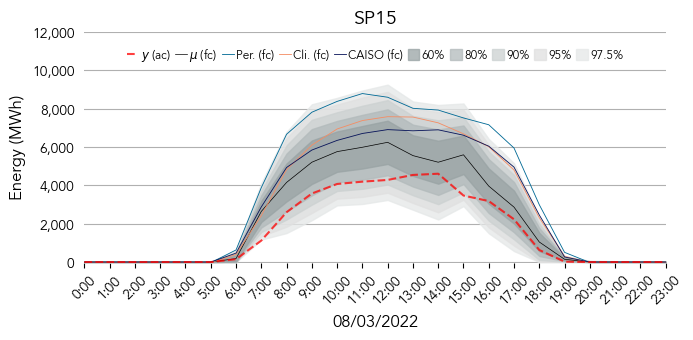

In [51]:
def _force_zero(x_):
    x_[x_ < 0.] = 0.
    return x_

def _plot_confidence_intervals(i_sel_sample, i_zone, _model, _baselines, legend    = True, 
                                                                         path      = '',
                                                                         linestyle = '--',
                                                                         save      = True, 
                                                                         file_name = 'noname.pdf', 
                                                                         letter    = 'A'):
    zone = zones_[i_zone]
    z_scores_ = [0.84, 1.28, 1.64, 1.96, 2.24]
    ci_       = [60, 80, 90, 95, 97.5]
    colors_   = ['#99A3A4', '#B2BABB', '#CCD1D1', '#E0E0E0', '#E5E8E8']

    y_       = _model['targets'][i_sel_sample, i_zone, :]
    mu_      = _model['mean'][i_sel_sample, i_zone, :]
    s2_      = np.sqrt(_model['variance'][i_sel_sample, i_zone, :])
    Y_scens_ = _force_zero(_model['samples'][i_sel_sample, i_zone, :, :])

    y_prs_ = _baselines['persitence'][i_sel_sample, i_zone, :]
    y_clm_ = _baselines['climatology'][i_sel_sample, i_zone, :]
    y_iso_ = _baselines['caiso'][i_sel_sample, i_zone, :]

    y_min = _model['samples'][:, i_zone, :, :].min()
    y_max = _model['samples'][:, i_zone, :, :].max()
    # y_min = 8000
    # y_max = 22000

    #scen_lable = f'{resource_labels_[i_resource]} {sl_model_labels_[i_sl_model]} & {dl_model_labels_[i_dl_model]}'

    x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)

    fig = plt.figure(figsize = (7.5, 3.))
    ax  = plt.subplot(111)

    #plt.title(r'{} ({})'.format(zone, meta_.loc[i_sel_sample, 'date']), fontsize = 14)

    plt.title(f'{zone}', fontsize = 14)

    ax.plot(x_, _force_zero(y_), color     = 'r', 
                                 linestyle = linestyle, 
                                 label     = r'$y$ (ac)',
                                 lw        = 1.5, 
                                 alpha     = .75, 
                                 zorder    = 12)


    ax.plot(x_, _force_zero(mu_), color     = 'k', 
                                  linestyle = '-', 
                                  label     = r'$\mu$ (fc)',
                                  lw        = .5, 
                                  alpha     = 1., 
                                  zorder    = 10)
    
    # colors_ = ['#7d6674', '#006995', '#f48d64', '#09155a', '#e6cd94', '#0041a5']
    ax.plot(x_, y_prs_, color     = '#006995', 
                        linestyle = '-', 
                        label     = r'Per. (fc)',
                        lw        = .6125, 
                        alpha     = 1., 
                        zorder    = 11)

    ax.plot(x_, y_clm_, color     = '#f48d64', 
                        linestyle = '-', 
                        label     = r'Cli. (fc)',
                        lw        = .6125, 
                        alpha     = 1., 
                        zorder    = 11)

    
    ax.plot(x_, y_iso_, color     = '#09155a', 
                        linestyle = '-', 
                        label     = r'CAISO (fc)',
                        lw        = .6125, 
                        alpha     = 1., 
                        zorder    = 11)

    i = 0
    for z, ci, color in zip(z_scores_, ci_, colors_):
        ax.fill_between(x_, _force_zero(mu_ + z*s2_), _force_zero(mu_ - z*s2_), color  = color, 
                                                                                label  = f'{ci:02}%', 
                                                                                alpha  = .75, 
                                                                                zorder = 7 - i)
        i += 1

    if legend:
        ax.legend(loc            = 'center', 
                  bbox_to_anchor = (.5, 0.9),
                  frameon        = False, 
                  columnspacing = 0.4, 
                  handletextpad = .2,
                  ncol           = 11,
                  prop           = {'size': 8.5})

    ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
    ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    plt.xlim(0, 23)

    ax.grid(axis = 'y')
    ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

    #ax.xaxis.set_tick_params(labelsize = 10, left = False)
    ax.yaxis.set_tick_params(labelsize = 10, left = False)

    y_max = 12000
    if y_min < 0.:
        y_min = -50
    plt.ylim(y_min, y_max)

    ax.text(-2.5, y_max*1.125, letter, fontsize = 20, 
                                      weight   = "bold")

    #ax.text(0., y_max*1.25, scen_lable, fontsize = 16)
    
#     ax.axvline(18, linewidth = .5, 
#                    linestyle = ':', 
#                    color     = 'k', 
#                    clip_on   = False, 
#                    zorder    = 10)

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)

    if save: plt.savefig(path + file_name, bbox_inches = 'tight', 
                                           dpi         = 250)


    plt.show()
    
    
i_sample = 10

i_sel_sample = np.argsort(X_['mean'].to_numpy())[i_sample]

_plot_confidence_intervals(i_sel_sample, i_zone, _model, _baselines, legend    = True, 
                                                                     path      = path_to_images,
                                                                     save      = True, 
                                                                     linestyle = '-',
                                                                     file_name = 'ci_{}-{}.png'.format(zones_[i_zone], i_sel_sample), 
                                                                     letter    = '')

i_sample = 2

i_sel_sample = np.argsort(X_['mean'].to_numpy())[::-1][i_sample]

_plot_confidence_intervals(i_sel_sample, i_zone, _model, _baselines, legend    = True, 
                                                                     path      = path_to_images,
                                                                     save      = True, 
                                                                     linestyle = '--',
                                                                     file_name = 'ci_{}-{}.png'.format(zones_[i_zone], i_sel_sample), 
                                                                     letter    = '')

In [52]:
# Rolling average window filter
def _smooth_average(X_, span): 
    N_dim, N_tasks, N_samples = X_.shape
    Y_                        = np.zeros(X_.shape)
    for i in range(N_dim):
        for j in range(N_samples):
            y_ = []
            for t in range(N_tasks):
                if t - span < 0: x = 0
                else:            x = t - span
                if t + span + 1 > N_tasks: y = N_tasks
                else:                      y = t + span + 1
                y_.append(np.average(X_[i, x:y, j]))
            Y_[i, :, j] = np.array(y_)
    return Y_

# Savitzky–Golay filter
def _smooth_savgol(X_, span, degree):  
    N_dim, N_tasks, N_samples = X_.shape
    Y_                        = np.zeros(X_.shape)
    for i in range(N_dim):
        for j in range(N_samples):
            Y_[i, :, j] = savgol_filter(X_[i, :, j], span * 2 + 1, degree)
    return Y_

# A LOWESS (Locally Weighted Scatterplot Smoothing) function that outs smoothed estimates 
def _smooth_lowess(X_, span):
    N_dim, N_tasks, N_samples = X_.shape
    Y_                        = np.zeros(X_.shape)
    x_                        = np.linspace(0, 1, N_tasks)
    for i in range(N_dim):
        for j in range(N_samples):
            Y_[i, :, j] = sm.nonparametric.lowess(X_[i, :, j], x_, frac          = 1/span, 
                                                                   return_sorted = False)
    return Y_

# def smooth_fft(X_, span, degree):  
#     N_dim, N_tasks, N_samples = X_.shape
#     Y_                        = np.zeros(X_.shape)
#     for i in range(N_dim):
#         for j in range(N_samples):
#             w_             = fftpack.rfft(X_[i, :, j])
#             spectrum       = w_ ** 2
#             cutoff_idx     = spectrum < (spectrum.max() * (1 - np.exp(-span / degree**2)))
#             w_[cutoff_idx] = 0
#             Y_[i, :, j]    = fftpack.irfft(w_)
#     return Y_

# Gaussian kernel filtering
def _smooth_gaussian(X_, sigma):
    N_dim, N_tasks, N_samples = X_.shape
    Y_                        = np.zeros(X_.shape)
    for i in range(N_dim):
        for j in range(N_samples):
            Y_[i, :, j] = gaussian_filter1d(X_[i, :, j], sigma)
    return Y_

# Evaluate a scenario's predictive probability
def _eval_proba(_model, Y_scens_, i_sel_sample):
    mu_      = _model['mean'][i_sel_sample, ...]
    Sigma_   = _model['covariance'][i_sel_sample, ...]

    Z_ = np.zeros((Y_scens_.shape[1], Y_scens_.shape[2]))
    for t in range(mu_.shape[1]):    
        Z_[t, :] = multivariate_normal(mu_[:, t], Sigma_[..., t]).pdf(Y_scens_[:, t, :].T)
    z_  = np.prod(Z_, axis = 0)
    z_ /= z_.sum()
    return z_

# Variogram Score computed across temporal dimensions
def _VS_temporal(Y_, Y_hat_, p = .5):
    N_observation, N_tasks, N_horizons, N_samples = Y_hat_.shape
    score_ = np.zeros((N_tasks, N_observation))
    for t in range(N_tasks):
        for n in range(N_observation):
            frac1_ = np.absolute(np.subtract.outer(Y_[n, t, :], Y_[n, t, :]))**p
            frac2_ = np.zeros((N_horizons, N_horizons))
            for m in range(N_samples):
                frac2_ += np.absolute(np.subtract.outer(Y_hat_[n, t, :, m], Y_hat_[n, t, :, m]))**p
            score_[t, n] = np.sum((frac1_ - (frac2_/N_samples))**2)
    return score_

# Energy Score
def _ES_temporal(Y_, Y_hat_):
    N_observation, N_tasks, N_horizons, N_samples = Y_hat_.shape
    score_ = np.zeros((N_tasks, N_observation))
    for t in range(N_tasks):
        for n in range(N_observation):
            Y_p_   = np.tile(Y_[n, t, :], (N_samples, 1)).T
            frac1_ = np.sqrt(np.diag((Y_hat_[n, t, :, :] - Y_p_).T @ (Y_hat_[n, t, :, :] - Y_p_)))
            frac2_ = 0
            for m in range(N_samples):
                frac2_ += np.sqrt(np.sum((Y_hat_[n, t, :, :].T - Y_hat_[n, t, :, m])**2, axis = 1))
            score_[t, n] = np.sum(frac1_)/N_samples - np.sum(frac2_)/(2*(N_samples**2))
    return score_

# Average variograme score
def _VS(Y_, Y_hat_):
    VS_ = _VS_temporal(Y_, Y_hat_, p = .5)
    VS_ = np.mean(VS_, axis = 1)
    VS_ = np.mean(VS_, axis = 0)
    return VS_

# Average energy score
def _ES(Y_, Y_hat_):
    ES_ = _ES_temporal(Y_, Y_hat_)
    ES_ = np.mean(ES_, axis = 1)
    ES_ = np.mean(ES_, axis = 0)
    return ES_

def _verify_confidence_intervals(Y_scens_, M_, S2_, z = 2.):
    
    N_in = 0.
    N_hours = 8
    for i_sample in range(M_.shape[0]):
        for i_zone in range(M_.shape[1]):
            for i_hour in [8, 9, 10, 11, 12, 13, 14, 15]:
                y_    = Y_scens_[i_sample, i_zone, i_hour, :]
                mu    = M_[i_sample, i_zone, i_hour]
                std   = np.sqrt(S2_[i_sample, i_zone, i_hour])
                idx_  = (y_ > (mu - z*std)) & (y_ < (mu + z*std))
                N_in += idx_.sum()
            
    return N_in/(Y_scens_.shape[0]*Y_scens_.shape[1]*N_hours*Y_scens_.shape[3])

# Log-Score
def _LogS(Y_, M_hat_, Cov_hat_):
    # Multivaritate Normal Log Predictive Probability
    def _mvNLPP(Y_, M_hat_, Cov_hat_):
        z_ = np.zeros((Y_.shape[0], ))
        for obv in range(M_hat_.shape[0]):
            z_[obv] = multivariate_normal(M_hat_[obv, ...], Cov_hat_[obv, ...], allow_singular = True).logpdf(Y_[obv, ...])
        return - z_    
    # Samples / Tasks / Forecasting horizons
    z_ = []
    for i_scen in range(Y_.shape[-1]):
        z_.append(np.sum(np.array([_mvNLPP(Y_[..., hrzn, i_scen], M_hat_[..., hrzn], Cov_hat_[..., hrzn]) for hrzn in [8, 9, 10, 11, 12, 13, 14, 15]]), axis = 1).mean())
    return np.array(z_).mean()


Y_     = _model['targets']
Y_hat_ = _model['samples']
print(Y_.shape, Y_hat_.shape)


M_  = _model['mean']
S2_ = _model['variance']
C_ = _model['covariance']
print(M_.shape, S2_.shape, C_.shape)

print(_verify_confidence_intervals(Y_hat_, M_, S2_, z = 1.96))
print(_ES(Y_, Y_hat_))
print(_VS(Y_, Y_hat_))
print(_LogS(Y_hat_, M_, C_))

print(df_)

(243, 3, 24) (243, 3, 24, 100)
(243, 3, 24) (243, 3, 24) (243, 3, 3, 24)
0.9361076817558299
1061.364557911165
18287.343824608175
5444.411488046824
Empty DataFrame
Columns: []
Index: [resource, sparse_method, dense_method, parameters, experiment, dimensions, score, training_time, testing_time, RMSE, LogS, ES, VS, IS60, IS80, IS90, IS95, IS975, RMSE_NP15, RMSE_SP15]


In [292]:
# 0.775 23985.05328434672 - load
# 0.95 24434.0527016360 - wind
# 0.475 18783.2435751563 - solar 
for sigma in [.37, .38, .39, .4, .41, .42, .43, .44, .45, .46, .47, .48]:
    Y_scens_ = np.zeros(Y_hat_.shape)
    for i in range(Y_hat_.shape[0]):
        Y_scens_[i, ...] = _smooth_gaussian(Y_hat_[i, ...], sigma = sigma)
    print(sigma, _VS(Y_, Y_scens_), _ES(Y_, Y_scens_), _verify_confidence_intervals(Y_scens_, M_, S2_, z = 1.96))

0.37 17923.793810762905 1058.7538752320977 0.9459139231824417
0.38 17869.91502029308 1058.510704205425 0.947690329218107
0.39 17817.755952759762 1058.3492037925153 0.9496844993141289
0.4 17769.019277438685 1058.2959469088125 0.9517112482853224
0.41 17725.524856554115 1058.3758973815236 0.9537431412894376
0.42 17688.911304123787 1058.6114249127634 0.9558213305898491
0.43 17660.633241019157 1059.021447838423 0.957863511659808
0.44 17640.574849084456 1059.6208758620876 0.9598439643347051
0.45 17629.534317041816 1060.4203567053135 0.9618329903978052
0.46 17627.73320079973 1061.4263013341504 0.963724279835391
0.47 17635.63162455962 1062.6411418394182 0.9656944444444444
0.48 17653.01710559377 1064.063764667302 0.9674657064471879


In [53]:
def _plot_scenarios(i_sel_sample, i_zone, _model, legend    = True, 
                                                  path      = '',
                                                  linestyle = '--',
                                                  save      = True, 
                                                  file_name = 'noname.pdf', 
                                                  letter    = 'A'):
    
    
    y_       = _model['targets'][i_sel_sample, i_zone, :]
    mu_      = _model['mean'][i_sel_sample, i_zone, :]
    Y_scens_ = _model['samples'][i_sel_sample, ...]

    #Y_scens_ = _force_zero(Y_scens_)
    #Y_scens_ = _smooth_average(Y_scens_, span = 1)
    #Y_scens_ = _smooth_lowess(Y_scens_, span = 1)
    #Y_scens_ = _smooth_savgol(Y_scens_, span = 11, degree = 15)
    Y_scens_ = _smooth_gaussian(Y_scens_, sigma = .46)

    z_ = _eval_proba(_model, Y_scens_, i_sel_sample)


    Y_scens_ = Y_scens_[i_zone, ...]

    y_min = _model['samples'][:, i_zone, :, :].min()
    y_max = _model['samples'][:, i_zone, :, :].max()
    
    # y_min = 8000
    # y_max = 22000

    #scen_lable = f'{resource_labels_[i_resource]} {sl_model_labels_[i_sl_model]} & {dl_model_labels_[i_dl_model]}'

    x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)

    fig = plt.figure(figsize = (7.5, 3.))
    ax  = plt.subplot(111)

    #plt.title(r'{} ({})'.format(zone, meta_.loc[i_sel_sample, 'date']), fontsize = 14)

    #plt.title(f'{zone}', fontsize = 14)

    ax.plot(x_, _force_zero(y_), color     = 'r', 
                                 linestyle = linestyle, 
                                 label     = '$y$ (ac)',
                                 lw        = 1.5, 
                                 alpha     = .75, 
                                 zorder    = 11)


    z_p_ = np.cbrt(np.cbrt(np.cbrt(z_)))
        
    _cmap = colors.LinearSegmentedColormap.from_list("my_colormap", ["lightgray", "silver", "gray", 'k'])
    #_cmap = plt.get_cmap('inferno') 

    _colormap = cm.ScalarMappable(norm = colors.Normalize(vmin = z_p_.min(), 
                                                          vmax = z_p_.max()), cmap = _cmap)
    _colormap.get_clim()


    for i in np.argsort(z_p_):
        
        if i == 0:
            ax.plot(x_, Y_scens_[:, i], color     = 'gray', 
                                        linestyle = '-', 
                                        label     = '$y^\star_k$ (sc)',
                                        lw        = 1., 
                                        alpha     = 1., 
                                        zorder    = 10)
            
        ax.plot(x_, Y_scens_[:, i], color     = _colormap.to_rgba(z_p_[i]), 
                                    linestyle = '-', 
                                    lw        = 1., 
                                    alpha     = .5, 
                                    zorder    = 10)

    if legend:
        ax.legend(loc            = 'center', 
                  bbox_to_anchor = (.85, 0.82),
                  frameon        = False, 
                  columnspacing = 0.5, 
                  handletextpad = .25,
                  ncol           = 2,
                  prop           = {'size': 10})
        
    ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
    ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    plt.xlim(0, 23)

    ax.grid(axis = 'y')
    ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

    #ax.xaxis.set_tick_params(labelsize = 10, left = False)
    ax.yaxis.set_tick_params(labelsize = 10, left = False)
    y_max = 12000
    if y_min < 0.:
        y_min = -5
    plt.ylim(y_min, y_max*1.1)

    ax.text(-2.5, y_max*1.25, letter, fontsize = 20, 
                                      weight   = "bold")

    #ax.text(0., y_max*1.25, scen_lable, fontsize = 15)

    ax.axhline(y_min, linewidth = .5, 
                      linestyle = '-', 
                      color     = 'k', 
                      clip_on   = False, 
                      zorder    = 10)

    # axins = inset_axes(ax,
    #                    width="20%",  
    #                    height="5%",
    #                    loc='top center')

    fig.colorbar(_colormap, orientation = "horizontal", 
                            cax         = fig.add_axes([0.165, 0.72, 0.15, 0.05])  ,
                            ticks       = [],
                            extend      = 'max').set_label(r'$Pr(y^\star_k | \hat{\theta}, X^\star)$', rotation = 0, 
                                                                                                       size     = 10)

    if save: plt.savefig(path + file_name, bbox_inches = 'tight', 
                                           dpi         = 250)


    plt.show()
    
i_sample = 10

i_sel_sample = np.argsort(X_['mean'].to_numpy())[i_sample]


_plot_scenarios(i_sel_sample_1, i_zone, _model, legend    = True, 
                                                save      = True, 
                                                linestyle = '-',
                                                path      = path_to_images,
                                                file_name = 'scen_{}-{}.png'.format(zones_[i_zone], i_sel_sample), 
                                                letter    = '')

i_sample = 2

i_sel_sample = np.argsort(X_['mean'].to_numpy())[::-1][i_sample]

_plot_scenarios(i_sel_sample, i_zone, _model, legend    = True, 
                                                save      = True, 
                                                path      = path_to_images,
                                                file_name = 'scen_{}-{}.png'.format(zones_[i_zone], i_sel_sample), 
                                                linestyle = '--',
                                                letter    = '')

NameError: name 'i_sel_sample_1' is not defined

In [203]:
M = 108
N = 80

plt.figure()
plt.imshow(_model['mask'].reshape(M, N)[::-1,] > 0)
plt.show()

idx_ = _model['mask'] > 0.
D    = idx_.sum()
F    = int(_model['weights'].shape[0]/D)
Z    = _model['weights'].shape[1]
print(D, F, Z)


dfs_ = []
for z in range(Z):   
    
    l2_norm = np.sqrt(np.sum(np.absolute(_model['weights'][:, z])**2))

    for f in range(F):

        df_     = pd.DataFrame(columns = ['weight', 'longitude', 'latitude', 'feature', 'zone'])               
        idx_sl_ = _model['weights'][f*D:(f+1)*D, z] != 0.
        df_['weight']    = weight_scale*np.absolute(_model['weights'][f*D:(f+1)*D, z][idx_sl_])/l2_norm
        df_['longitude'] = W_ref_[idx_, 0][idx_sl_]
        df_['latitude']  = W_ref_[idx_, 1][idx_sl_]
        df_['feature']   = features_[i_resource][f]
        df_['zone']      = z

        dfs_.append(df_)
        
df_ = pd.concat(dfs_).reset_index(drop = True)
print(df_)
print(df_['weight'].sum())

NameError: name 'M' is not defined

<Figure size 640x480 with 0 Axes>